# Consumption Equivalent Variation (CEV)

1. Use the model in the **ConsumptionSaving.pdf** slides and solve it using **egm**
2. This notebooks estimates the *cost of income risk* through the Consumption Equivalent Variation (CEV) 

We will here focus on the cost of income risk, but the CEV can be used to estimate the value of many different aspects of an economy. For eaxample, [Oswald (2019)](http://qeconomics.org/ojs/index.php/qe/article/view/701 "The option value of homeownership") estimated the option value of homeownership using a similar strategy as described below.

**Goal:** To estimate the CEV by comparing the *value of life* under the baseline economy and an alternative economy with higher permanent income shock variance along with a consumption compensation.

**Value of Life:** 
1. Let the *utility function* be a generalized version of the CRRA utility function with $\delta$ included as a potential consumption compensation. 
\begin{equation}
{u}(c,\delta) = \frac{(c\cdot(1+\delta))^{1-\rho}}{1-\rho}
\end{equation}
2. Let the *value of life* of a synthetic consumer $s$ for a given level of permanent income shock varaince, $\sigma_{\psi}$, and $\delta$, be
\begin{equation}
{V}_{s}({\sigma}_{\psi},\delta)=\sum_{t=1}^T \beta ^{t-1}{u}({c}^{\star}_{s,t}({\sigma}_{\psi},\delta),\delta)
\end{equation}
where ${c}^{\star}_{s,t}({\sigma}_{\psi},\delta)$ is optimal consumption found using the **egm**. The value of life is calcualted in the function `value_of_life(.)` defined below.

**Consumption Equivalent Variation:** 
1. Let $V=\frac{1}{S}\sum_{s=1}^SV(\sigma_{\psi},0)$ be the average value of life under the *baseline* economy with the baseline value of $\sigma_{\psi}$ and $\delta=0$.
2. Let $\tilde{V}(\delta)=\frac{1}{S}\sum_{s=1}^SV(\tilde{\sigma}_{\psi},\delta)$ be the average value of life under the *alternative* economy with $\tilde{\sigma}_{\psi} > \sigma_{\psi}$.

The CEV is the value of $\delta$ that sets $V=\tilde{V}(\delta)$ and can be estimated as 
\begin{equation}
\hat{\delta} = \arg\min_\delta (V-\tilde{V}(\delta))^2
\end{equation}
where the objective function is calculated in `obj_func_cev(.)` defined below.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import scipy.optimize as optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import sys
sys.path.append('../')

from consav import jit
import ConsumptionSavingModel as csm
from ConsumptionSavingModel import ConsumptionSavingModelClass

# Setup the baseline model and the alternative model

In [2]:
par = {'simT':40}
model = ConsumptionSavingModelClass(name='baseline',par=par)

# increase the permanent income with 100 percent and allow for consumption compensation
par_cev = {'sigma_psi':0.2,'do_cev':1,'simT':40}
model_cev = ConsumptionSavingModelClass(name='cev',par=par_cev)

In [3]:
model.solve()
model.simulate()

model solved in 3.1 secs
model simulated in 3.4 secs


# Average value of life 

**Define Functions:** value of life and objective function used to estimate "cev"

In [4]:
def value_of_life(model):
    
    # utility associated with consumption for all N and T
    with jit(model) as model_jit: 
        util = csm.utility(model_jit.sim.c,model_jit.par)
    
    # discounted sum of utility
    disc = np.ones(model.par.simT)
    disc[1:] = np.cumprod(np.ones(model.par.simT-1)*model.par.beta)
    
    disc_util = np.sum(disc*util,axis=1)
    
    # return average of discounted sum of utility
    return np.mean(disc_util)    

def obj_func_cev(theta,model_cev,value_of_life_baseline):
    
    # update cev-parameter
    setattr(model_cev.par,'cev',theta)
    
    # re-solve and simulate alternative model
    model_cev.solve(do_print=False)
    model_cev.simulate(do_print=False)
    
    # calculate value of life
    value_of_life_cev = value_of_life(model_cev)
    
    # return squared difference to baseline
    return (value_of_life_cev - value_of_life_baseline)*(value_of_life_cev - value_of_life_baseline)


**Baseline value of life and objective function at cev=0**

In [5]:
value_of_life_baseline = value_of_life(model)
obj_func_cev(0.0,model_cev,value_of_life_baseline)

3.46846115430638

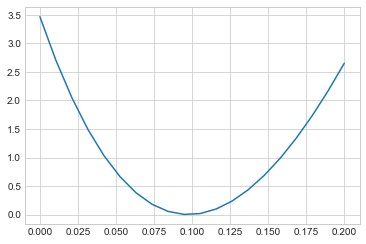

In [6]:
# plot the objective function
grid_cev = np.linspace(0.0,0.2,20)
grid_obj = np.empty(grid_cev.size)

for j,cev in enumerate(grid_cev):
    grid_obj[j] = obj_func_cev(cev,model_cev,value_of_life_baseline)
    
plt.plot(grid_cev,grid_obj);   

# Estimate the Consumption Equivalent Variation (CEV)

In [7]:
res = optimize.minimize_scalar(obj_func_cev, bounds=[-0.01,0.5], 
                               args=(model_cev,value_of_life_baseline),method='golden')
res

     fun: 9.21421081920921e-18
    nfev: 48
     nit: 43
 success: True
       x: 0.0975865281411968

The estimated CEV suggests that consumers would be indifferent between the baseline economy and a 100% increase in the permanent income shock variance along with a 10% increase in consumption in all periods.